In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
obesity = pd.read_csv("/content/obesity_data.csv")
print(obesity.head())

   Age  Gender      Height     Weight        BMI  PhysicalActivityLevel  \
0   56    Male  173.575262  71.982051  23.891783                      4   
1   69    Male  164.127306  89.959256  33.395209                      2   
2   46  Female  168.072202  72.930629  25.817737                      4   
3   32    Male  168.459633  84.886912  29.912247                      3   
4   60    Male  183.568568  69.038945  20.487903                      3   

  ObesityCategory  
0   Normal weight  
1           Obese  
2      Overweight  
3      Overweight  
4   Normal weight  


In [3]:
# Data Exploration

print(obesity.describe())

print(obesity.isna().any())

print(obesity.isna().sum())

               Age       Height       Weight          BMI  \
count  1000.000000  1000.000000  1000.000000  1000.000000   
mean     49.857000   170.052417    71.205769    24.888317   
std      18.114267    10.309971    15.509849     6.193912   
min      18.000000   136.115719    26.065730     8.470572   
25%      35.000000   163.514205    61.129629    20.918068   
50%      50.000000   169.801665    71.929072    24.698647   
75%      66.000000   177.353596    81.133746    28.732132   
max      79.000000   201.419670   118.907366    50.791898   

       PhysicalActivityLevel  
count            1000.000000  
mean                2.534000  
std                 1.116284  
min                 1.000000  
25%                 2.000000  
50%                 3.000000  
75%                 4.000000  
max                 4.000000  
Age                      False
Gender                   False
Height                   False
Weight                   False
BMI                      False
PhysicalActivity

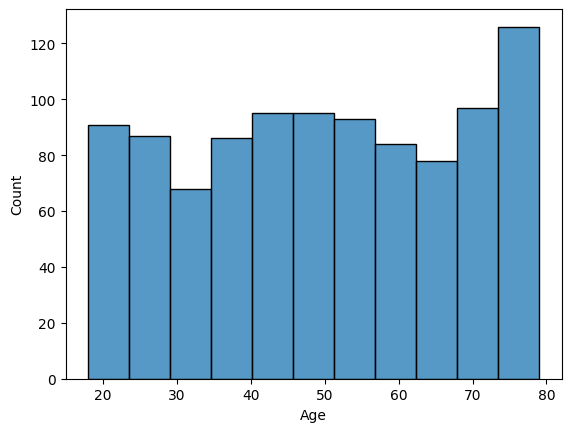

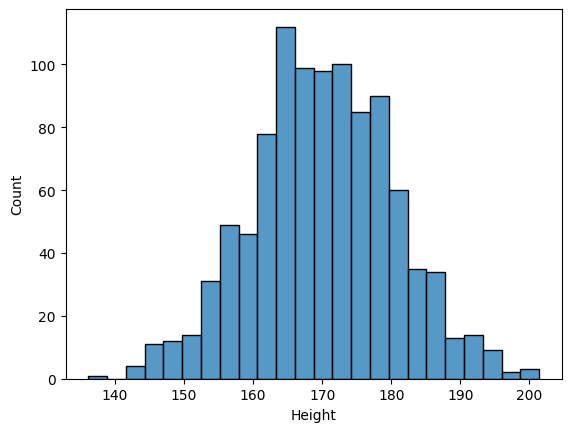

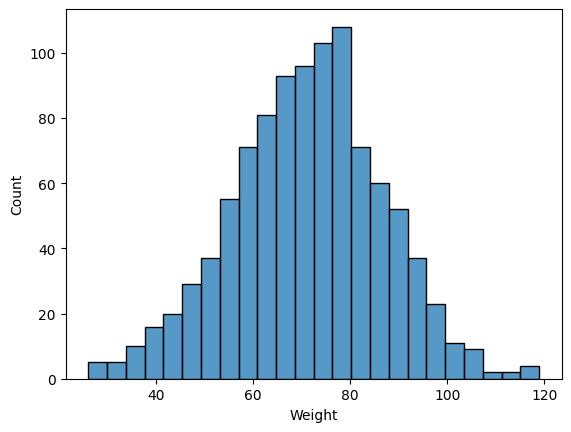

In [4]:
sns.histplot(data=obesity, x="Age")
plt.show()

sns.histplot(data=obesity, x="Height")
plt.show()

sns.histplot(data=obesity, x="Weight")
plt.show()

<ipython-input-5-7213cc91c116>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Gender", data=obesity, palette="Set3")  # Use a visually appealing color palette


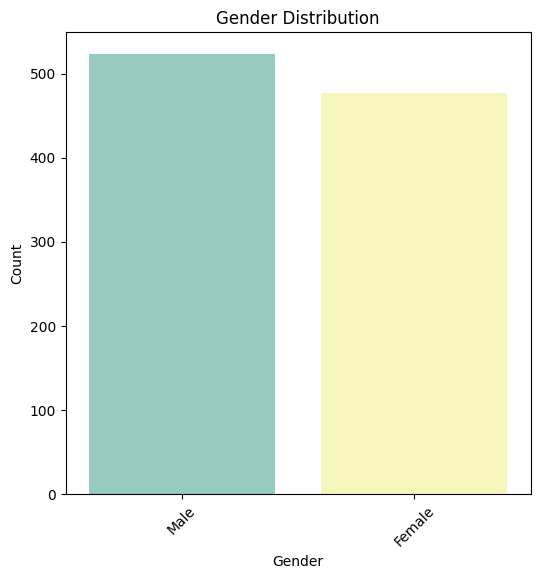

In [5]:
plt.figure(figsize=(6, 6))  # Set the figure size
sns.countplot(x="Gender", data=obesity, palette="Set3")  # Use a visually appealing color palette
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

plt.show()

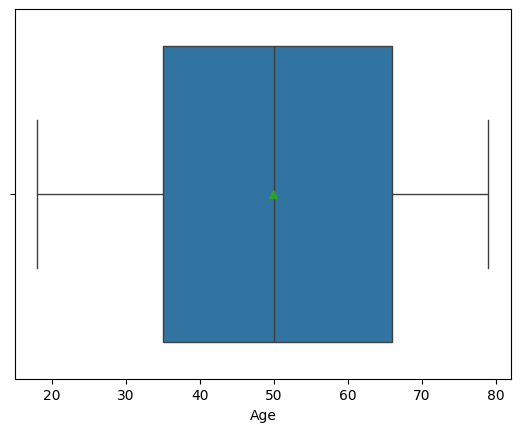

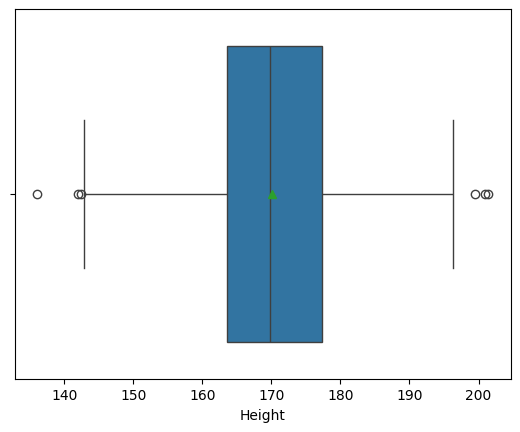

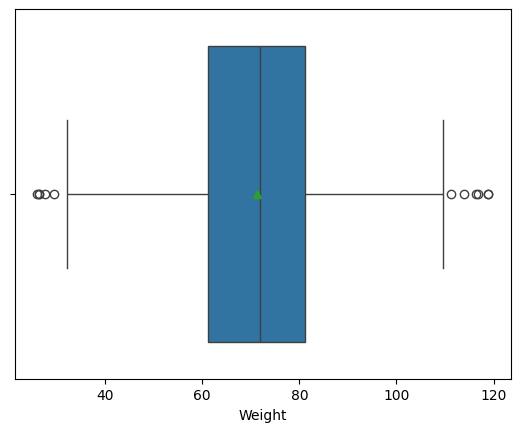

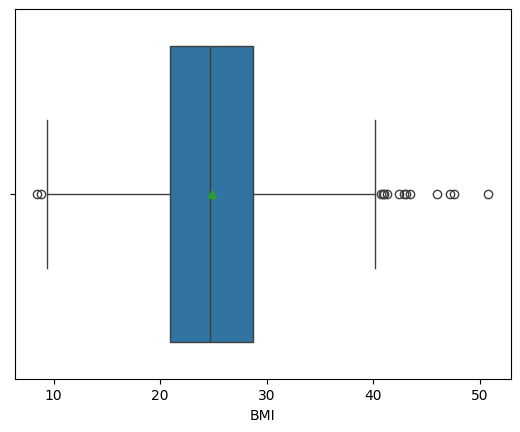

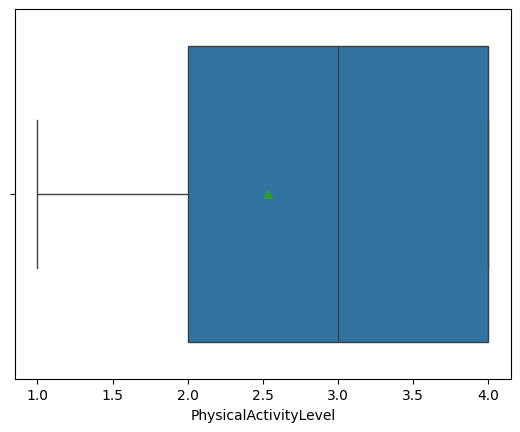

In [6]:
# Get a list of numeric columns (excluding categorical ones like Gender)
cols = ["Age", "Height", "Weight", "BMI", "PhysicalActivityLevel"]

for col in cols:
    sns.boxplot(x = col, showmeans=True, data=obesity)
    plt.show()

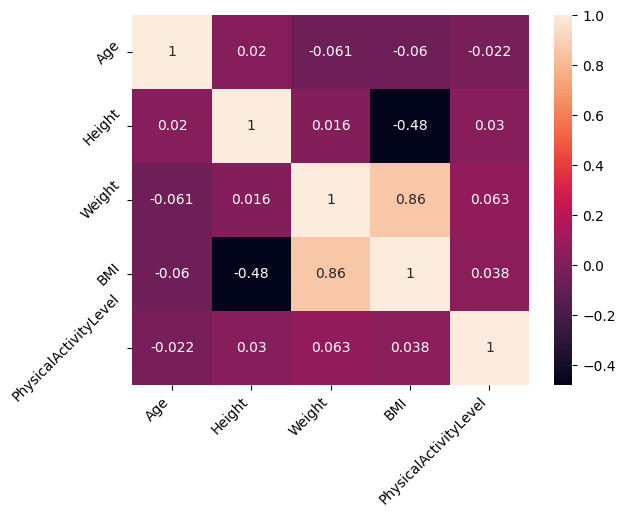

In [7]:
corr = obesity.drop(["Gender", "ObesityCategory"], axis=1).corr()
g = sns.heatmap(corr, annot=True)

# rotate the ticks 45 degrees for the sake of redability
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')


plt.show()

**We can see that there's strong correlation between Weight and BMI, also there is a decent negative correlation between BMI and Height which makes perfect sense if you look at the BMI equation**

![](https://www.usz.ch/app/uploads/2023/10/bmi-calculator-en-scaled.jpg)

**we might even Drop the Weight and Height columns!**

In [8]:
print(set(obesity["ObesityCategory"]))

{'Obese', 'Overweight', 'Normal weight', 'Underweight'}


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

final_scores = []

# XGBoost Classifier

In [10]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_xgboost = []

# Loop through the folds
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create an instance of the XGBoost classifier
    model = XGBClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Add the accuracy to the list
    accuracies_xgboost.append(accuracy)

# Compute the mean accuracy
accuracy_score_avg = np.mean(accuracies_xgboost)

print("Average Accuracy XGBoost Before Optimization: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"XGBoost", "Optimized":False, "Accuracy":accuracy_score_avg*100})

Average Accuracy XGBoost Before Optimization: 99.50%


# XGBoost Optimized

In [11]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_xgboost = []

# Define the parameter space for the random search
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 1, 2, 3],
    'reg_lambda': [0, 1, 2, 3],
    'n_jobs': [-1],
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=0,
    random_state=42
)

# Fit the model to the data
random_search.fit(X, y)

# Append the best scoreto the list of accuracies
accuracies_xgboost.append(random_search.best_score_)
accuracy_score_avg = np.mean(accuracies_xgboost)

print("Average Accuracy XGBoost After Optimization: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"XGBoost", "Optimized":True, "Accuracy":accuracy_score_avg*100})

Average Accuracy XGBoost After Optimization: 99.80%


# Random Forest Classifier

In [12]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_random_forest = []

# Loop through the folds
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create an instance of the Random Forest classifier
    model = RandomForestClassifier(random_state=42)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy ofthe model
    accuracy = accuracy_score(y_test, y_pred)

    # Add the accuracy to the list
    accuracies_random_forest.append(accuracy)

# Compute the mean accuracy
accuracy_score_avg = np.mean(accuracies_random_forest)

print("Average Accuracy: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"Random Forest", "Optimized":False, "Accuracy":accuracy_score_avg*100})

Average Accuracy: 99.80%


# Random Forest Optimized

In [13]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_random_forest = []

# Define the parameter space for the random search
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False],
    'n_jobs': [-1],
}

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=0,
    random_state=42
)

# Fit the model to the data
random_search.fit(X, y)

# Append the best score to the list of accuracies
accuracies_random_forest.append(random_search.best_score_)
accuracy_score_avg = np.mean(accuracies_random_forest)

print("Average Accuracy Random Forest After Optimization: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"Random Forest", "Optimized":True, "Accuracy":accuracy_score_avg*100})

Average Accuracy Random Forest After Optimization: 99.90%


# KNN Classifier

In [14]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_knn = []

# Loop through the folds
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create an instance of the KNN classifier
    model = KNeighborsClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Add the accuracy to the list
    accuracies_knn.append(accuracy)

# Compute the mean accuracy
accuracy_score_avg = np.mean(accuracies_knn)

print("Average Accuracy: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"KNN", "Optimized":False, "Accuracy":accuracy_score_avg*100})

Average Accuracy: 91.60%


# KNN Optimized

In [15]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_knn = []

# Define the parameter space for the random search
param_dist = {
    'n_neighbors': [i for i in range(1, 16)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': np.arange(10, 51, 10),
    'p': np.arange(1, 6),
    'n_jobs': [-1],
}

# Initialize the KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=knn_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=0,
    random_state=42
)

# Fit the model to the data
random_search.fit(X, y)

# Append the best score to thelist of accuracies
accuracies_knn.append(random_search.best_score_)
accuracy_score_avg = np.mean(accuracies_knn)

print("Average Accuracy KNN After Optimization: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"KNN", "Optimized":True, "Accuracy":accuracy_score_avg*100})

Average Accuracy KNN After Optimization: 93.30%


# Decision Tree Classifier

In [16]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_decision_tree = []

# Loop through the folds
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create an instance of the Decision Tree classifier
    model = DecisionTreeClassifier()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Add the accuracy to the list
    accuracies_decision_tree.append(accuracy)

# Compute the mean accuracy
accuracy_score_avg = np.mean(accuracies_decision_tree)

print("Average Accuracy: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"Decision Tree", "Optimized":False, "Accuracy":accuracy_score_avg*100})

Average Accuracy: 99.80%


# Decision Tree Optimized

In [17]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the accuracy scores
accuracies_tree = []

# Define the parameter space for the random search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(10, 51)],
    'min_samples_split': [i for i in range(2,51)],
    'min_samples_leaf': [i for i in range(1, 9)],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42],
}

# Initialize the Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=tree_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=0,
    random_state=42
)

# Fit the model to the data
random_search.fit(X, y)

# Append the best score to the list of accuracies
accuracies_tree.append(random_search.best_score_)
accuracy_score_avg = np.mean(accuracies_tree)

print("Average Accuracy Decision Tree After Optimization: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"Decision Tree", "Optimized":True, "Accuracy":accuracy_score_avg*100})

Average Accuracy Decision Tree After Optimization: 98.20%


# Naïve Bayes Classifier

In [18]:
# Drop unnecessary columns
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary for Gender
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

y = obesity['ObesityCategory'].map(mapping)

# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Initialize an empty list to store the accuracy scores
accuracies_gnb = []

# Set up a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the folds
for train_index, test_index in skf.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the classifier to the training data
    gnb.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = gnb.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Add the accuracy to the list
    accuracies_gnb.append(accuracy)

# Compute the mean accuracy
accuracy_score_avg = np.mean(accuracies_gnb)

print("Average Accuracy: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"Naive Bayes", "Optimized":False, "Accuracy":accuracy_score_avg*100})

Average Accuracy: 98.50%


# Naive Bayes Optimized

In [19]:
X = obesity.drop(['ObesityCategory', "Weight", "Height"], axis=1)
X["Gender"] = [1 if i == "Male" else 0 for i in X["Gender"]]

# Create a mapping dictionary
mapping = {'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obese': 3}

# Use the map function to apply the mapping
y = obesity['ObesityCategory'].map(mapping)

# Define the parameter space for the random search
param_dist = {
    'var_smoothing': [1e-1, 1e-3, 1e-5, 1e-7, 1e-9],
}

nb_clf = GaussianNB()

random_search = RandomizedSearchCV(
    estimator=nb_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=0,
    random_state=42
)

# Fit the model to the data
random_search.fit(X, y)

# Append the best score to the list of accuracies
accuracies_nb = []
accuracies_nb.append(random_search.best_score_)
accuracy_score_avg = np.mean(accuracies_nb)

print("Average Accuracy Gaussian Naive Bayes After Optimization: %.2f%%" % (accuracy_score_avg * 100.0))

final_scores.append({"Model":"Naive Bayes", "Optimized":True, "Accuracy":accuracy_score_avg*100})

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Average Accuracy Gaussian Naive Bayes After Optimization: 98.50%


# Plot The Accuracy Scores of Models Before and After Optimization

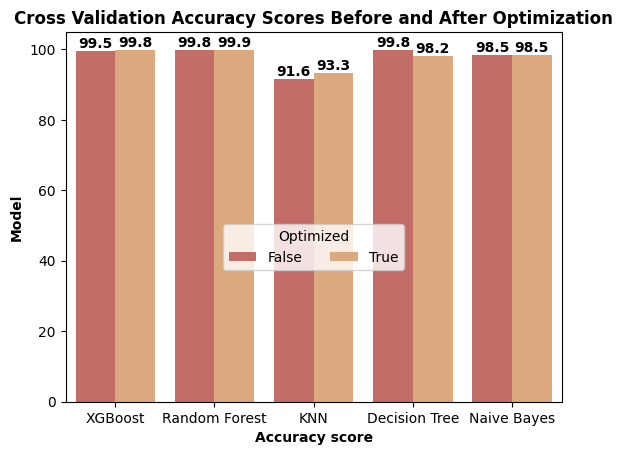

In [20]:
final_scores = pd.DataFrame(final_scores)

final_scores["Accuracy"] = [round(i, 3) for i in final_scores["Accuracy"]]

sns.set_palette("Spectral", n_colors=6, desat=0.8)

ax = sns.barplot(data=final_scores, y="Accuracy", x="Model", hue="Optimized")

plt.title("Cross Validation Accuracy Scores Before and After Optimization",
          fontweight="bold")
ax.bar_label(ax.containers[0], fontweight="bold")
ax.bar_label(ax.containers[1], fontweight="bold")
plt.xlabel("Accuracy score", fontweight="bold")
plt.ylabel("Model", fontweight="bold")

# Move the legend to the center of the plot
plt.legend(bbox_to_anchor=(0.5, 0.5), loc=9, ncol=3, title="Optimized")

plt.show()